In [0]:
import torch
from torch import nn
import numpy as np
import os
import re
import random
from scipy import stats
from collections import defaultdict

## Load Data

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Corpus/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! ls gdrive/My\ Drive/Corpus

bg_wiki_text.tar.lzma  pl_wiki_text.tar.lzma
cs_wiki_text.tar.lzma  ru_wiki_text.tar.lzma


In [0]:
! tar --lzma -xvf gdrive/My\ Drive/Corpus/pl_wiki_text.tar.lzma
! tar --lzma -xvf gdrive/My\ Drive/Corpus/ru_wiki_text.tar.lzma
! tar --lzma -xvf gdrive/My\ Drive/Corpus/bg_wiki_text.tar.lzma
! tar --lzma -xvf gdrive/My\ Drive/Corpus/cs_wiki_text.tar.lzma

./pl//full.txt
./ru//full.txt
./bg//full.txt
./cs//full.txt


In [0]:
LANGS = ['bg', 'cs', 'pl', 'ru']
MAX_LEN = 800
MIN_LEN = 60
MAX_LINES = 150000
data_dict = {l: [] for l in LANGS}

In [0]:
for lang in LANGS:
    print(lang)
    f = open(os.path.join(lang, 'full.txt'))
    for l in f:
        if re.match(r'\[\[[0-9]*\]\]', l) \
            or re.match(r'align =', l) \
            or len(l) == 0 \
            or len(l) > MAX_LEN \
            or len(l) < MIN_LEN:
            continue
        data_dict[lang].append(l.strip())
        #if len(data_dict[lang]) > MAX_LINES:
        #    break
    data_dict[lang] = random.sample(data_dict[lang], MAX_LINES)

bg
cs
pl
ru


In [0]:
len_dict = {}
for lang in LANGS:
    print(len(data_dict[lang]))
    len_dict[lang] = list(map(len, data_dict[lang]))

150000
150000
150000
150000


In [0]:
for lang in LANGS:
    l = len_dict[lang]
    print(lang)
    print('mode:', stats.mode(l).mode[0])
    print('mean:', np.mean(l))
    print('median:', np.median(l))
    print()

bg
mode: 61
mean: 129.22226666666666
median: 112.0

cs
mode: 61
mean: 126.9294
median: 111.0

pl
mode: 92
mean: 125.88850666666667
median: 109.0

ru
mode: 65
mean: 138.33240666666666
median: 119.0



In [0]:
DATA = []
for lang in LANGS:
    DATA.extend(list(map(
        lambda x: (x, lang),
        data_dict[lang]
    )))

In [0]:
del data_dict
del len_dict

In [0]:
def iterate_data(data, batch_size=32, shuffle=True):
    data = np.array(data)
    if shuffle:
        np.random.shuffle(data)
    for start in range(0, len(data), batch_size):
        end = min(len(data), start + batch_size)
        batch = data[start:end]
        sents, langs = zip(*batch)
        yield sents, langs


In [0]:
from gc import collect
collect()

11

In [0]:
sents_only, _ = zip(*DATA)

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline 
from IPython.display import clear_output

In [0]:
def plot_history(train_history):
    if len(train_history) == 0:
        return
    metrics = train_history.keys()
    n = len(metrics)
    fig, ax = plt.subplots((n + 1) // 2, 2, figsize=(15, 10))
    
    for i, metric in enumerate(metrics):
        train_arr = train_history[metric]
        ax[i // 2, i % 2].plot(list(range(len(train_arr))), train_arr, label='train')
        ax[i // 2, i % 2].set_title(metric)
        ax[i // 2, i % 2].set_xlabel('train steps')
        ax[i // 2, i % 2].set_ylabel(metric)
        ax[i // 2, i % 2].legend()
    plt.show()

## Model

In [0]:
class CharLM(nn.Module):
    _ALLOWED_LANGUAGE_MODES = ['concat', 'add', 'learn_h0', None]
    def __init__(self, char2idx, embedding_size, lstm_hidden, language_mode=None, language_list=None, lang_embedding_size=None, gpu=True):
        super().__init__()
        lstm_input_size = embedding_size
        # language processing
        if language_mode is None:
            self.language_mode = None
        elif language_mode == 'concat':
            self.language_mode = 'concat'
            if lang_embedding_size is None:
                raise ValueError('concat mode selected, but language emedding size not provided')
            self.lang_embedding_size = lang_embedding_size
            lstm_input_size += lang_embedding_size
        elif language_mode == 'add':
            self.language_mode = 'add'
            self.lang_embedding_size = embedding_size
        else:
            raise ValueError('language mode must be in %s, but %s provided' % (CharLM._ALLOWED_LANGUAGE_MODES, language_mode))

        if self.language_mode:
            self.language_embs = nn.ParameterDict(
                {lang: nn.Parameter(torch.randn(self.lang_embedding_size, requires_grad=True)) for lang in language_list}
            )

        # char embedding
        self.char_embeddings = nn.Embedding(len(char2idx), embedding_size, padding_idx=0)
        # lstm
        self.lstm_hidden = lstm_hidden
        self.lstm = nn.LSTM(lstm_input_size, lstm_hidden, batch_first=True, bidirectional=True)
        # linear layer
        self.linear_forward = nn.Linear(lstm_hidden, len(char2idx))
        self.linear_backward = nn.Linear(lstm_hidden, len(char2idx))
        # loss
        self.loss = nn.CrossEntropyLoss(ignore_index=0)

        self.char2idx = char2idx
        self.device = 'cuda' if gpu else 'cpu'

    def forward(self, x):
        # TODO add initial state for learn h0
        if self.language_mode == 'learn_h0':
            raise NotImplementedError("learning initial hidden state is not implemented yet")
        else:
            h0, c0 = None, None
        x, _ = self.lstm(x)
        bsz = x.batch_sizes[0]
        x = nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)[0]
        bsz, max_len, _ = x.size()
        x = x.view(bsz, max_len, 2, self.lstm_hidden)
        return x[:, :, 0], x[:, :, 1] # forward, backward

    def calc_loss(self, sentences, langs):
        embeded, indexed_sents = self.embed_and_pack(sentences, langs)
        lstm_forward, lstm_backward = self(embeded)
        # TODO make sure this the correct order
        # print(lstm_forward.size(), lstm_backward.size())
        preds_f = self.linear_forward(lstm_forward)
        preds_b = self.linear_backward(lstm_backward)
        # print(preds_f.size(), preds_b.size(), indexed_sents.size())
        loss_f = self.loss(preds_f[:, :-1].reshape(-1, len(self.char2idx)), indexed_sents[:, 1:].reshape(-1))
        # set end token to 0, which is ignored by the loss function
        backward_mask = (indexed_sents != self.char2idx['<END>'])[:, :-1]
        loss_b = self.loss(preds_b[:, 1:].reshape(-1, len(self.char2idx)), (indexed_sents[:, :-1] * backward_mask).reshape(-1))
        return loss_f, loss_b
        
    @staticmethod
    def build_char_dict(corpus, special_tokens=['<PAD>', '<START>', '<END>', '<UNK>']):
        chars = set()
        for doc in corpus:
            for char in doc:
                chars.add(char)
        char_list = special_tokens + list(sorted(chars))
        char2idx = {char: idx for idx, char in enumerate(char_list)}
        idx2char = {idx: char for idx, char in enumerate(char_list)}
        return char2idx, idx2char

    def get_lang_embdding_matrix(self, langs, max_len):
        bsz = len(langs)
        res = torch.empty(bsz, max_len, self.lang_embedding_size, device=self.device)
        for idx, lang in enumerate(langs):
            res[idx] = self.language_embs[lang].unsqueeze(0).repeat((max_len, 1))
        return res

    def embed_words(self, tokenized_sentences, langs):
        joined_sentences = list(map(
            lambda sentence: ' '.join(sentence),
            tokenized_sentences
        ))
        embeded, indexed_sents = self.embed_and_pack(joined_sentences, langs)
        forward, backward = self(embeded)
        res = [None] * len(tokenized_sentences)
        for idx, sent in enumerate(tokenized_sentences):
            cur_pos = 1
            res[idx] = torch.empty(len(sent), self.lstm_hidden * 2)
            for widx, word in enumerate(sent):
                femb = forward[idx, cur_pos + len(word) - 1]
                bemb = backward[idx, cur_pos]
                cur_pos += len(word) + 1
                res[idx][widx, :self.lstm_hidden] = femb
                res[idx][widx, self.lstm_hidden:] = bemb
        return res

    def embed_and_pack(self, sentences, langs): # build tensor of shape bsz * max_len
        # declare variables
        batch_lens = [None] * len(sentences)
        max_len = len(max(sentences, key=len)) + 2 # start and end token
        res = torch.zeros(len(sentences), max_len, dtype=torch.long).to(self.device)
        if self.language_mode in ('concat', 'add'):
            lang_emb = self.get_lang_embdding_matrix(langs, max_len)

        # process documents
        for i, sent in enumerate(sentences):
            idxed_sent = [self.char2idx['<START>']] + list(map(lambda char: self.char2idx.get(char, char2idx['<UNK>']), sent)) + [self.char2idx['<END>']]
            res[i, :len(idxed_sent)] = torch.tensor(idxed_sent, device=self.device, dtype=torch.long)
            batch_lens[i] = len(idxed_sent)
        batch_lens = torch.tensor(batch_lens, device=self.device, dtype=torch.long)
        idxed_sent = res
        res = self.char_embeddings(res)

        # add language information if needed
        if self.language_mode == 'concat':
            res = torch.cat((res, lang_emb), dim=-1)
        elif self.language_mode == 'add':
            res += lang_emb

        # pack sequence
        res = nn.utils.rnn.pack_padded_sequence(res, batch_lens, batch_first=True, enforce_sorted=False)
        return res, idxed_sent



In [0]:
char2idx, idx2char = CharLM.build_char_dict(sents_only)

In [0]:
import pickle

In [0]:
print(len(char2idx))

2511


In [0]:
with open("./gdrive/My Drive/CHARM_LMS/char2idx_small_lr", 'wb') as f:
    pickle.dump(char2idx, f)

In [0]:
LANGS = ['bg', 'pl', 'cs', 'ru']
models = [
    {
        'name': "Concat lang",
        'path': "./gdrive/My Drive/CHARM_LMS/512_512_concat_128_lr0.0001",
        'params': {
            'language_mode': 'concat',
            'lang_embedding_size': 128,
            'language_list': LANGS,
        }
    },
    {
        'name': 'No lang',
        'path': "./gdrive/My Drive/CHARM_LMS/512_512_none_lr0.0001",
        'params': {
            'language_mode': None,
            'lang_embedding_size': None,
            'language_list': LANGS,
        }
    },
    {
        'name': 'Add lang',
        'path': "./gdrive/My Drive/CHARM_LMS/add_512_512_1500it_lr0.0001",
        'params': {
            'language_mode': 'add',
            'lang_embedding_size': None,
            'language_list': LANGS,
        }
    }
]

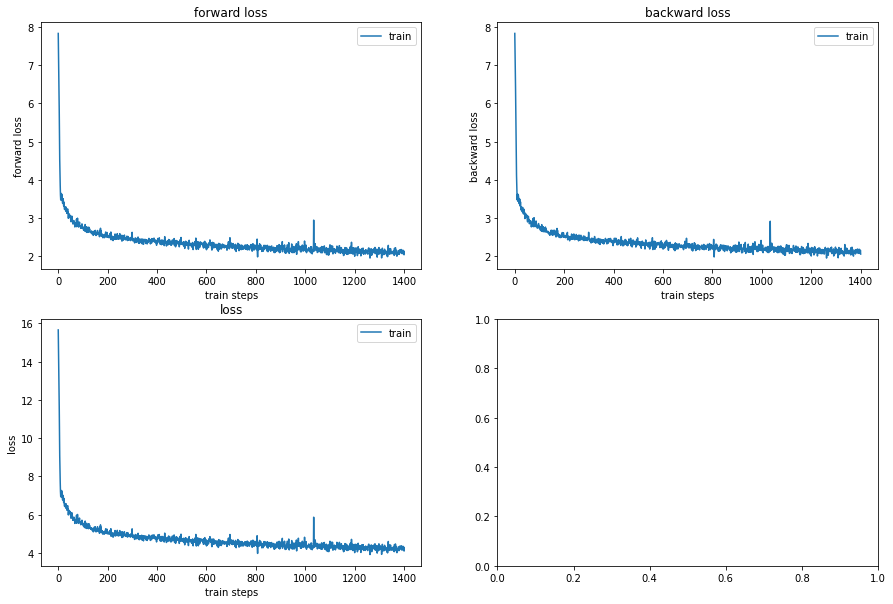

In [0]:
initial_lr = 1e-4
lr_alpha = 0.8
lr_step = 10
iters_in_step = 100
for model_desc in models:
    print(model_desc['name'])
    model = CharLM(char2idx, 512, 512, **model_desc['params']).cuda()
    opt = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=lr_step)
    history = defaultdict(list)
    it = 0
    for sents, langs in iterate_data(DATA):
        opt.zero_grad()
        f_loss, b_loss = model.calc_loss(sents, langs)
        history['forward loss'].append(f_loss.item())
        history['backward loss'].append(b_loss.item())
        history['loss'].append(f_loss.item() + b_loss.item())
        loss = f_loss + b_loss
        loss.backward()
        opt.step()
        if it and (it % iters_in_step == 0):
            if it == 1500:
                torch.save(model.state_dict(), model_desc['path'])
                break
            clear_output()
            plot_history(history)
        it += 1

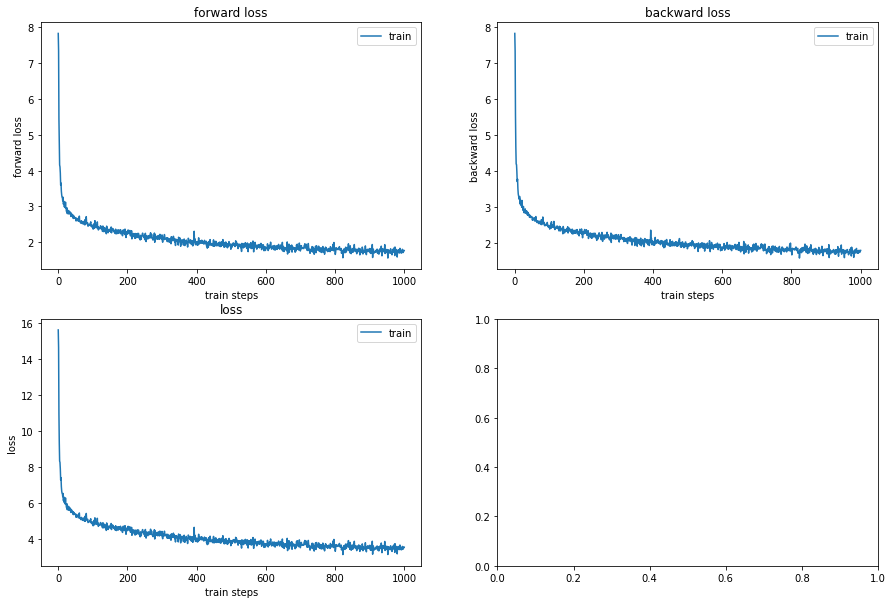

In [0]:
history = defaultdict(list)
it = 0
for sents, langs in iterate_data(DATA):
    opt.zero_grad()
    f_loss, b_loss = model.calc_loss(sents, langs)
    history['forward loss'].append(f_loss.item())
    history['backward loss'].append(b_loss.item())
    history['loss'].append(f_loss.item() + b_loss.item())
    loss = f_loss + b_loss
    loss.backward()
    opt.step()
    if it and (it % iters_in_step == 0):
        if it == 1500:
            
            break
        clear_output()
        plot_history(history)
    it += 1

In [0]:
model.embed_words([['собака', 'прибежала', 'ко', 'мне']], ['ru'])

[tensor([[-6.9256e-01,  3.9186e-01, -2.1398e-01,  ..., -9.5009e-01,
           8.4564e-04,  2.6861e-01],
         [-7.4922e-01,  5.8609e-01,  1.4432e-01,  ...,  2.5681e-02,
           3.8313e-03,  8.2492e-02],
         [-9.2311e-01,  2.2631e-02, -2.2945e-01,  ..., -1.2402e-02,
           3.5126e-03,  3.1770e-01],
         [-1.4690e-02,  5.0458e-02, -4.8326e-01,  ..., -5.3070e-01,
           9.9648e-01,  6.0513e-03]], grad_fn=<CopySlices>)]

In [0]:
torch.save(model.state_dict, './gdrive/My Drive/CHARM_LMS/AA')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CharLM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [0]:
param_dict = {}
for l, p in model.language_embs.items():
    param_dict[l] = p.data.cpu().numpy()
vals = param_dict.values()
vals = np.vstack(vals)
print(cosine_similarity(vals))
print(euclidean_distances(vals))

[[ 1.0000001  -0.08807459  0.08675887 -0.18195748]
 [-0.08807459  1.0000001  -0.02988976  0.03975259]
 [ 0.08675887 -0.02988976  1.0000001  -0.04697676]
 [-0.18195748  0.03975259 -0.04697676  1.0000002 ]]
[[ 0.       16.766706 15.201137 17.60394 ]
 [16.766706  0.       16.553753 16.260098]
 [15.201137 16.553753  0.       16.811644]
 [17.60394  16.260098 16.811644  0.      ]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """
